In [1]:
# Import libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy as sp
from scipy import optimize
import pandas as pd
from os import listdir
from os.path import isfile, join
from datetime import datetime
from scipy.stats import linregress

Because we have so many files here, we need to extract the filenames and put it in pandas. In each file name, we have the date and time of the measurement, the line, and the wavelength

In [2]:
# The path to the files
mypath = "OTDR data/"

# Acquire all of the filenames
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))][:-2]
print(onlyfiles)

['Fiber_Meas_OTDR_2022-06-01_16-32-14_Line01_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-32-42_Line03_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-35-20_Line01_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-35-49_Line03_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-38-28_Line01_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-38-56_Line03_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-15-17_Line01_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-15-50_Line03_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-18-49_Line01_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-19-21_Line03_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-22-16_Line01_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-22-47_Line03_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_19-56-26_Line01_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_19-56-58_Line03_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_19-59-49_Line01_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_20-00-21_Line03_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_20-03-13_Line01_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_20

In [3]:
# Make a function to extract information from the names.
def extract_info(fname):
    _,_,_, date_raw, time_raw, line_raw, wl_raw = fname.split("_")
    combined_time = date_raw + '_' + time_raw
    datetime_obj = datetime.strptime(combined_time, "%Y-%m-%d_%H-%M-%S")
    return datetime_obj, int(line_raw[-2:]), int(wl_raw[:4])

In [4]:
# make a function to create the filenames
def make_fname(datetime_obj, line, wl):
    return f'OTDR data/Fiber_Meas_OTDR_{datetime_obj.strftime("%Y-%m-%d_%H-%M-%S")}_Line0{line}_{wl}nm.txt'

In [5]:
wl_list = [1310, 1550, 1625]
line_list = [1,3]


This will be a little bit of a brute force

In [6]:
fnames_1310_1 = []
fnames_1310_3 = []
fnames_1550_1 = []
fnames_1550_3 = []
fnames_1625_1 = []
fnames_1625_3 = []

In [7]:
for fname in onlyfiles:
    time, line, wl = extract_info(fname)
    if wl == 1310:
        if line == 1:
            fnames_1310_1.append(time)
        elif line == 3:
            fnames_1310_3.append(time)
    elif wl == 1550:
        if line == 1:
            fnames_1550_1.append(time)
        elif line == 3:
            fnames_1550_3.append(time)
    elif wl == 1625:
        if line == 1:
            fnames_1625_1.append(time)
        elif line == 3:
            fnames_1625_3.append(time)
        

In [8]:
time_array = np.array([[fnames_1310_1, fnames_1310_3], [fnames_1550_1, fnames_1550_3], [fnames_1625_1, fnames_1625_3]])

n_time = time_array.shape[-1]

In [9]:
relative_time_array = np.zeros_like(time_array)
initial_time = time_array[:,:,0]
for i in range(3):
    for j in range(2):
        for k in range(n_time):
            relative_time_array[i,j,k] = (time_array[i,j,k] - initial_time[i,j]).total_seconds()/3600

#print(relative_time_array.shape)
#print(relative_time_array[0,0])

Now we are going to try reading the data, starting from 1310 nm line 1

In [10]:
scan_length = 150
scan_time = 10
sample_line1 = np.loadtxt(make_fname(time_array[0,0,0], 1, 1310), skiprows=13)
sample_line2 = np.loadtxt(make_fname(time_array[0,0,150], 1, 1310), skiprows=13)
sample_line3 = np.loadtxt(make_fname(time_array[0,0,385], 1, 1310), skiprows=13)

length_increment = scan_length/len(sample_line1-1)
print(length_increment)
length_array = np.linspace(0,150,len(sample_line1))

0.03996802557953637


length: 27.19 meters


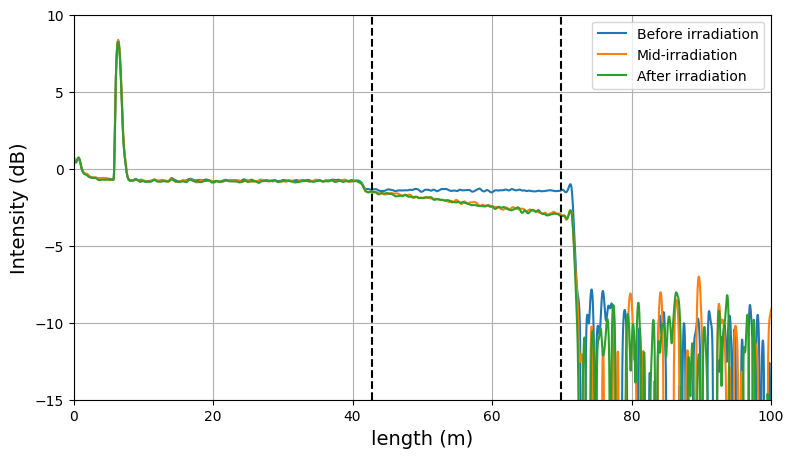

In [11]:
min_idx = 1070
max_idx = 1750
fig, ax = plt.subplots(1,1, figsize = (9,5))
ax.plot(length_array, sample_line1, label = "Before irradiation")
ax.plot(length_array, sample_line2, label = "Mid-irradiation")
ax.plot(length_array, sample_line3, label = "After irradiation")
ax.set_xlabel("length (m)", fontsize = 14)
ax.set_ylabel("Intensity (dB)", fontsize = 14)
ax.grid(True)
ax.set_xlim([0,100])
ax.set_ylim([-15, 10])
ax.axvline(min_idx*length_increment, color = 'black', linestyle = '--')
ax.axvline(max_idx*length_increment, color = 'black', linestyle = '--')
ax.legend()
plt.plot()
print(f"length: {(length_array[max_idx] - length_array[min_idx]):.2f} meters")


Now we are going to make matrices for each line and wavelength

In [12]:
matrix_1310_1 = np.array([np.loadtxt(make_fname(time_array[0,0,i], 1, 1310), skiprows=13) for i in range(n_time)])
matrix_1310_3 = np.array([np.loadtxt(make_fname(time_array[0,1,i], 3, 1310), skiprows=13) for i in range(n_time)])
matrix_1550_1 = np.array([np.loadtxt(make_fname(time_array[1,0,i], 1, 1550), skiprows=13) for i in range(n_time)])
matrix_1550_3 = np.array([np.loadtxt(make_fname(time_array[1,1,i], 3, 1550), skiprows=13) for i in range(n_time)])
matrix_1625_1 = np.array([np.loadtxt(make_fname(time_array[2,0,i], 1, 1625), skiprows=13) for i in range(n_time)])
matrix_1625_1 = np.array([np.loadtxt(make_fname(time_array[2,1,i], 3, 1625), skiprows=13) for i in range(n_time)])

In [13]:
# Put start and end index
idx_start_1310_1 = 1070
idx_end_1310_1 = 1750

TIA_1310_1 = np.zeros(n_time)

for i in range(n_time):
    intensities = matrix_1310_1[i,idx_start_1310_1:idx_end_1310_1]
    lengths = length_array[idx_start_1310_1:idx_end_1310_1]
    TIA_1310_1[i] = linregress(lengths, intensities).slope

# Get the actual TIA
TIA_1310_1 = (TIA_1310_1[0]-TIA_1310_1)


(0.0, 641.8747222222222)

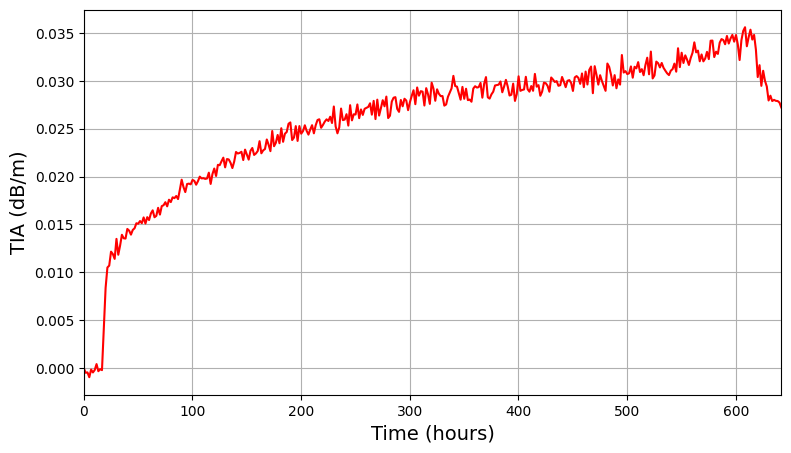

In [14]:
fig_TIA, ax_TIA = plt.subplots(1,1, figsize = (9,5))
ax_TIA.plot(relative_time_array[0][0],TIA_1310_1, color = 'red')
ax_TIA.grid(True)
ax_TIA.set_xlabel("Time (hours)", fontsize = 14)
ax_TIA.set_ylabel("TIA (dB/m)", fontsize = 14)
ax_TIA.set_xlim((relative_time_array[0][0][0], relative_time_array[0][0][-1]))